# Lasso Scenario Creation Quickstart

In this notebook we will run through:

1. Using a configuration file to run lasso  
2. Setting up a base scenario and applying projects  
3. Transforming the standard network format to the MetCouncil expected format    
4. Exporting the network to a shapefile and csvs  

In [6]:
import os
import sys
import yaml

import pandas as pd

from network_wrangler import RoadwayNetwork
from network_wrangler import TransitNetwork
from network_wrangler import ProjectCard
from network_wrangler import Scenario
from network_wrangler import WranglerLogger

from lasso import ModelRoadwayNetwork
from lasso import StandardTransit

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import logging
logger = logging.getLogger("WranglerLogger")
logger.handlers[0].stream = sys.stdout
# if you don't want to see so much detail, set to logging.INFO or DEBUG
logger.setLevel(logging.DEBUG)

## Read a Config File

Let's examine the configuration file and store it as `my_config` variable.  

Configuration files are written in YAML and read in as python dictionaries.

In [9]:
MY_CONFIG_FILE = os.path.join(
    os.path.dirname(os.path.abspath('')), "examples", "settings","my_config.yaml"
)

with open(MY_CONFIG_FILE) as f:
        my_config = yaml.safe_load(f)
        
import json
print(json.dumps(my_config, indent=2))

## Alternatively this could be written in the notebook our selected via a notebook GUI

{
  "base_scenario": {
    "input_dir": "examples/stpaul",
    "shape_file_name": "shape.geojson",
    "link_file_name": "link.json",
    "node_file_name": "node.geojson",
    "transit_directory": "",
    "validate_network": false
  },
  "scenario": {
    "project_cards_filenames": [],
    "card_directory": "examples/stpaul/project_cards",
    "glob_search": "*simple*.yml",
    "tags": []
  },
  "output": {
    "format": "geojson",
    "directory": "",
    "prefix": ""
  }
}


## Create a Base Scenario

Base scenarios must at the least specify a highway network but can also specify a directory where transit networks can be found.  

In this step the highway and transit networks are read in and validated to each other.  

In some cases, you may want to override the validation (after reviewing the errors) using the flag: `validate = False`.

In [10]:
base_wrangler_path = os.path.join(os.path.dirname((os.path.dirname(os.path.abspath('')))),"network_wrangler")
WranglerLogger.info("Base Wrangler Path: {}".format(base_wrangler_path))

base_scenario = Scenario.create_base_scenario(
        my_config["base_scenario"]["shape_file_name"],
        my_config["base_scenario"]["link_file_name"],
        my_config["base_scenario"]["node_file_name"],
        roadway_dir=os.path.join(base_wrangler_path,my_config["base_scenario"]["input_dir"]),
        transit_dir=os.path.join(base_wrangler_path,my_config["base_scenario"]["input_dir"]),
        validate=False
    )

2020-05-21 11:06:06, INFO: Base Wrangler Path: D:\network_wrangler
2020-05-21 11:06:06, INFO: Reading from following files:
-D:\network_wrangler\examples/stpaul\link.json
-D:\network_wrangler\examples/stpaul\node.geojson
-D:\network_wrangler\examples/stpaul\shape.geojson.
2020-05-21 11:06:31, INFO: Read 66253 links from D:\network_wrangler\examples/stpaul\link.json
2020-05-21 11:06:31, INFO: Read 17159 nodes from D:\network_wrangler\examples/stpaul\node.geojson
2020-05-21 11:06:31, INFO: Read 66253 shapes from D:\network_wrangler\examples/stpaul\shape.geojson
2020-05-21 11:07:08, INFO: Read in transit feed from: D:\network_wrangler\examples/stpaul
2020-05-21 11:07:08, DEBUG: ...agency.txt:
  agency_id       agency_name                   agency_url  agency_timezone  \
0         0     Metro Transit  http://www.metrotransit.org  America/Chicago   
1         2     Metro Transit  http://www.metrotransit.org  America/Chicago   
2         3  Minnesota Valley          http://www.mvta.com  Amer

2020-05-21 11:07:08, DEBUG: ...frequencies.txt:
                             trip_id  headway_secs  start_time  end_time
0  14940701-JUN19-MVS-BUS-Weekday-01          3600     21600.0   32400.0
1  14941148-JUN19-MVS-BUS-Weekday-01           830     21600.0   32400.0
2  14941151-JUN19-MVS-BUS-Weekday-01           540     21600.0   32400.0
3  14941153-JUN19-MVS-BUS-Weekday-01           696     32400.0   54000.0
4  14941163-JUN19-MVS-BUS-Weekday-01           830     32400.0   54000.0
5  14942968-JUN19-MVS-BUS-Weekday-01          5400     21600.0   32400.0
6  14943414-JUN19-MVS-BUS-Weekday-01          2160     21600.0   32400.0
7  14943415-JUN19-MVS-BUS-Weekday-01          5400     21600.0   32400.0
8  14944019-JUN19-MVS-BUS-Weekday-01           526     32400.0   54000.0
9  14944022-JUN19-MVS-BUS-Weekday-01           771     21600.0   32400.0
2020-05-21 11:07:09, DEBUG: ...shapes.txt:
  shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence shape_osm_node_id  \
0  4520004     44.923257   

In [11]:
base_wrangler_path = os.path.join(os.path.dirname((os.path.dirname(os.path.abspath('')))),"network_wrangler")
WranglerLogger.info("Base Wrangler Path: {}".format(base_wrangler_path))
base_scenario = Scenario.create_base_scenario(
        my_config["base_scenario"]["shape_file_name"],
        my_config["base_scenario"]["link_file_name"],
        my_config["base_scenario"]["node_file_name"],
        roadway_dir=os.path.join(base_wrangler_path,my_config["base_scenario"]["input_dir"]),
        transit_dir=os.path.join(base_wrangler_path,my_config["base_scenario"]["input_dir"]),
        validate = False,
    )

2020-05-21 11:07:43, INFO: Base Wrangler Path: D:\network_wrangler
2020-05-21 11:07:43, INFO: Reading from following files:
-D:\network_wrangler\examples/stpaul\link.json
-D:\network_wrangler\examples/stpaul\node.geojson
-D:\network_wrangler\examples/stpaul\shape.geojson.
2020-05-21 11:08:07, INFO: Read 66253 links from D:\network_wrangler\examples/stpaul\link.json
2020-05-21 11:08:07, INFO: Read 17159 nodes from D:\network_wrangler\examples/stpaul\node.geojson
2020-05-21 11:08:07, INFO: Read 66253 shapes from D:\network_wrangler\examples/stpaul\shape.geojson
2020-05-21 11:08:43, INFO: Read in transit feed from: D:\network_wrangler\examples/stpaul
2020-05-21 11:08:43, DEBUG: ...agency.txt:
  agency_id       agency_name                   agency_url  agency_timezone  \
0         0     Metro Transit  http://www.metrotransit.org  America/Chicago   
1         2     Metro Transit  http://www.metrotransit.org  America/Chicago   
2         3  Minnesota Valley          http://www.mvta.com  Amer

2020-05-21 11:08:43, DEBUG: ...frequencies.txt:
                             trip_id  headway_secs  start_time  end_time
0  14940701-JUN19-MVS-BUS-Weekday-01          3600     21600.0   32400.0
1  14941148-JUN19-MVS-BUS-Weekday-01           830     21600.0   32400.0
2  14941151-JUN19-MVS-BUS-Weekday-01           540     21600.0   32400.0
3  14941153-JUN19-MVS-BUS-Weekday-01           696     32400.0   54000.0
4  14941163-JUN19-MVS-BUS-Weekday-01           830     32400.0   54000.0
5  14942968-JUN19-MVS-BUS-Weekday-01          5400     21600.0   32400.0
6  14943414-JUN19-MVS-BUS-Weekday-01          2160     21600.0   32400.0
7  14943415-JUN19-MVS-BUS-Weekday-01          5400     21600.0   32400.0
8  14944019-JUN19-MVS-BUS-Weekday-01           526     32400.0   54000.0
9  14944022-JUN19-MVS-BUS-Weekday-01           771     21600.0   32400.0
2020-05-21 11:08:43, DEBUG: ...shapes.txt:
  shape_id  shape_pt_lat  shape_pt_lon  shape_pt_sequence shape_osm_node_id  \
0  4520004     44.923257   

#### Create project cards from projects that are explicitely specified in config


In [12]:
if len(my_config["scenario"]["project_cards_filenames"]) > 0:
    project_cards_list = [
        ProjectCard.read(filename, validate=False)
        for filename in my_config["scenario"]["project_cards_filenames"]
    ]
else: 
    project_cards_list = []
project_cards_list

[]

## Create Scenario

A scenario is constructed with a base scenario and then selecting project cards to be added to that base scenario to create the new scenario.

Projects can be added a variety of ways:

 1. `card_directory` + `tags` will search a directory add project's who's project tags match *at least one of* the tags in the keyword.
 2. `card_directory` + `glob_search` will search a directory add project's who's file name matches the [glob search text](https://docs.python.org/3/library/glob.html)
 3. `project_cards_list` is a list of ProjectCard objects
 
Optionally, you may specify that project card formats are not validated by setting they keyword: 
   `validate = False`
   
Projects that are not added in the initial scenario development can be added by using the following methods:  

 - `add_project_card_from_file()`  
 - `add_project_cards_from_directory()`  
 - `add_project_cards_from_tags`
 
Or by directly adding the project to the scenario's project attribute by running:

```python
my_project = ProjectCard.read(path_to_card)
my_scenario.projects += my_project

```


In [13]:
my_scenario=None

my_scenario = Scenario.create_scenario(
    base_scenario=base_scenario,
    card_directory=os.path.join(base_wrangler_path,my_config["scenario"]["card_directory"]),
    tags=my_config["scenario"]["tags"],
    project_cards_list=project_cards_list,
    glob_search=my_config["scenario"]["glob_search"],
    validate_project_cards=False,
)

2020-05-21 11:09:18, INFO: Creating Scenario
2020-05-21 11:09:31, DEBUG: Adding project cards from directory.
Dir: D:\network_wrangler\examples/stpaul/project_cards
2020-05-21 11:09:31, DEBUG: Adding project cards using glob search: *simple*.yml
2020-05-21 11:09:31, DEBUG: Trying to add project card from file: D:\network_wrangler\examples/stpaul/project_cards\10_simple_roadway_add_change.yml
2020-05-21 11:09:31, DEBUG: Adding project card to scenario: test simple roadway add
2020-05-21 11:09:31, DEBUG: Adding project card dependencies
2020-05-21 11:09:31, DEBUG: Trying to add project card from file: D:\network_wrangler\examples/stpaul/project_cards\13_simple_roadway_delete_change.yml
2020-05-21 11:09:31, DEBUG: Adding project card to scenario: test simple roadway deletion
2020-05-21 11:09:31, DEBUG: Trying to add project card from file: D:\network_wrangler\examples/stpaul/project_cards\1_simple_roadway_attribute_change.yml
2020-05-21 11:09:31, DEBUG: Adding project card to scenario: 6t

### Apply all projects in scenario

In [14]:
WranglerLogger.info("\nProjects in queue to be applied: \n - {}".format("\n - ".join(my_scenario.get_project_names())))
WranglerLogger.info("\n[Before] Applied Projects: \n - {}".format("\n - ".join(my_scenario.applied_projects)))

my_scenario.apply_all_projects()

WranglerLogger.info("\n[After] Applied Projects: \n - {}".format("\n - ".join(my_scenario.applied_projects)))

2020-05-21 11:09:32, INFO: 
Projects in queue to be applied: 
 - test simple roadway add
 - test simple roadway deletion
 - 6th St E Road Diet
 - test managed lane project
 - Blue Line Service Enhancement A
 - Blue Line Service Enhancement C
 - Improve Express Bus Frequency
2020-05-21 11:09:32, INFO: 
[Before] Applied Projects: 
 - 
2020-05-21 11:09:32, DEBUG: Ordered Project Cards: {'improve express bus frequency': <network_wrangler.projectcard.ProjectCard object at 0x0000019856DB4748>, 'blue line service enhancement c': <network_wrangler.projectcard.ProjectCard object at 0x0000019856DB41C8>, 'blue line service enhancement a': <network_wrangler.projectcard.ProjectCard object at 0x0000019856DB4648>, 'test managed lane project': <network_wrangler.projectcard.ProjectCard object at 0x0000019856DB4908>, '6th st e road diet': <network_wrangler.projectcard.ProjectCard object at 0x0000019856DC45C8>, 'test simple roadway deletion': <network_wrangler.projectcard.ProjectCard object at 0x00000198

d:\network_wrangler\network_wrangler\roadwaynetwork.py:880: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_links["i"] = 0
d:\network_wrangler\network_wrangler\roadwaynetwork.py:962: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_links["i"] * RoadwayNetwork.SP_WEIGHT_FACTOR


2020-05-21 11:09:33, DEBUG: Completed query
2020-05-21 11:09:33, DEBUG: Not a unique ID selection, conduct search
2020-05-21 11:09:33, DEBUG: Foreign key list: [39425, 62146, 68609, 41991]
2020-05-21 11:09:33, DEBUG: calculating shortest path from graph
2020-05-21 11:09:33, DEBUG: _shortest_path(): calculating shortest path from graph
2020-05-21 11:09:33, DEBUG: creating network graph
2020-05-21 11:09:33, DEBUG: starting ox_graph()
2020-05-21 11:09:33, DEBUG: GRAPH NODES: Index(['model_node_id', 'osm_node_id', 'shstReferenceId', 'drive_node',
       'walk_node', 'bike_node', 'bus_only', 'rail_only', 'geometry', 'x',
       'y'],
      dtype='object')
2020-05-21 11:09:33, DEBUG: starting ox.gdfs_to_graph()
2020-05-21 11:09:33, DEBUG: finished ox.gdfs_to_graph()
2020-05-21 11:09:33, DEBUG: Calculating NX shortest path from A_id: 39425 to B_id: 62146
2020-05-21 11:09:33, DEBUG: Shortest path successfully routed
2020-05-21 11:09:33, WARNING: Existing value defined for lanes in project card

d:\network_wrangler\network_wrangler\roadwaynetwork.py:847: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate_links["i"] = 0


2020-05-21 11:09:33, WARNING: Roadway Deletion not yet implemented in Transit; ignoring
2020-05-21 11:09:33, INFO: Applying test simple roadway add
2020-05-21 11:09:33, INFO: Applying Project to Roadway Network: test simple roadway add
2020-05-21 11:09:33, INFO: 
[After] Applied Projects: 
 - Improve Express Bus Frequency
 - Blue Line Service Enhancement C
 - Blue Line Service Enhancement A
 - test managed lane project
 - 6th St E Road Diet
 - test simple roadway deletion
 - test simple roadway add


# Write out as MetCouncil Model Roadway Network
Everything above was done in "pure wrangler" rather than lasso.  However, we will need Lasso in order to add the MetCouncil specific variables. You can create a lasso ModelRoadwayNetwork object from the roadway network object and feed it any additional parameters from that `my_config` variable.

You can see that the link variables for this network are the same as the standard roadway network at this point but that will change.

Since this is a GeoDataFrame you can also use build-in Geopandas features to make simple plots based on these variables.

In [15]:
model_road_net = ModelRoadwayNetwork.from_RoadwayNetwork(
    my_scenario.road_net, parameters=my_config.get("my_parameters", {})
)

WranglerLogger.info("\nmodel_road_net columns:\n - {}".format("\n - ".join(model_road_net.links_df.columns)))

2020-05-21 11:10:07, INFO: Lasso base directory set as: D:\lasso
2020-05-21 11:10:07, INFO: 
model_road_net columns:
 - model_link_id
 - osm_link_id
 - shstReferenceId
 - shstGeometryId
 - u
 - v
 - A
 - B
 - locationReferences
 - distance
 - roadway
 - name
 - ref
 - bridge
 - tunnel
 - width
 - max_speed
 - bike_facility
 - drive_access
 - walk_access
 - bike_access
 - truck_access
 - bus_only
 - rail_only
 - lanes
 - access
 - price
 - trn_priority
 - ttime_assert
 - geometry
 - managed
 - ML_lanes
 - ML_price
 - ML_access
 - ML_egress
 - transit_access


AttributeError: 'Series' object has no attribute 'type'

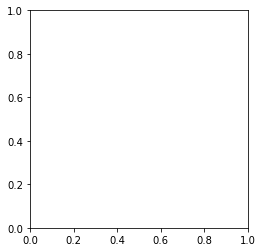

In [17]:
model_road_net.links_df.plot("bike_access")

## Add MetCouncil variables
At this point, we need to calculate all the variables into what MetCouncil's model is expecting. The method `roadway_standard_to_met_council_network()` broadly does the following:  
 
- creates a parallel managed lane network
- calculates additional variables based on geography or other variables (i.e. county, assignment group, area type, etc)
- flattens variables stored as continuous time values and determines their value by time period (i.e. lanes_am)   
- reprojects into MetCouncil's projection

In [ ]:
model_road_net.roadway_standard_to_met_council_network()

In [ ]:
WranglerLogger.info("\nmodel_road_net **links_metcouncil** columns:\n - {}".format("\n - ".join(model_road_net.links_metcouncil_df.columns)))

In [ ]:
model_road_net.links_metcouncil_df.plot("lanes_AM")

## Export to shapefile

As a last step, the network can be exported to a shapefile and paired CSVs after removing extraneous variables.

(note that this step will also run the `roadway_standard_to_met_council_network()` method but I wanted to show it to you piecewise)

In [ ]:
model_road_net.write_roadway_as_shp()

# Export to fixed width file

In [ ]:
model_road_net.write_roadway_as_fixedwidth()

# Write out as MetCouncil Model Transit Network

Similar to the roadway network, the first step is to convert it to a Lasso object, and then write it to a cube line file.  Optionally, you could also export it to a shapefile to inspect using other means. 

In [ ]:
standard_transit = StandardTransit.fromTransitNetwork(my_scenario.transit_net)
standard_transit.feed

Write out the StandardTransit Lasso object to a cube line file:

In [ ]:
standard_transit.write_as_cube_lin()